##### 1. Установим нужные библиотеки

In [1]:
# %pip install seaborn==0.13.0

In [39]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

/Users/nikolaistepanov/.pyenv/versions/3.11.3/lib/python3.11/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/nikolaistepanov/.pyenv/versions/3.11.3/lib/python3.11/site-packages/pydantic/_internal/_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


##### 1. Определим глобальные перменные

In [2]:
TABLE_NAME = "users_churn"

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "churn_nikolaistepanov"
RUN_NAME = "eda"

ASSETS_DIR = "assets"

##### 2. Заберем данные из базы данных и сформируем `dataframe`. Для этого указываем:
- host базы данных
- port базы данных
- название базы данных
- логин и пароль от базых данных

Также дополнительно:
- `sslmode` (verify-full требует использование SSL, проверку сертификата сервера и проверку имени хоста сервера)
- `target-session-attrs` (параметр, используемый при подключении к кластеру базы данных с использованием протокола PostgreSQL)

###### Все чувствительные данные получаем из переменных окружения при помощи библиотеки `os`

In [4]:
connection = {"sslmode": "verify-full", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("POSTGRES_HOST"),
    "port": os.getenv("POSTGRES_PORT"),
    "dbname": os.getenv("POSTGRES_DBNAME"),
    "user": os.getenv("POSTGRES_USER"),
    "password": os.getenv("POSTGRES_PASSWORD"),
}

connection.update(postgres_credentials)

In [5]:
with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

In [6]:
df.head(2)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,1,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,DSL,...,0,0,0,0,Female,0,1,0,0,0
1,2,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,DSL,...,1,0,0,0,Male,0,0,0,0,0


##### 3. Первичный анализ данных

- общая информация про `dataframe`
- размер `dataframe`
- пропуски в данных
- дубликаты
- уникальные значения

In [7]:
os.mkdir(ASSETS_DIR)

In [8]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")

In [9]:
df.head(3)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,1,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,1,0,0,0,0,Female,0,1,0,0,0
1,2,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,DSL,1,0,1,0,0,0,Male,0,0,0,0,0
2,3,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,1,0,0,0,0,Male,0,0,0,0,1


In [10]:
df.tail(3)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
7040,7041,4801-JZAZL,2019-03-01,NaT,Month-to-month,1,Electronic check,29.60,346.45,DSL,1,0,0,0,0,0,Female,0,1,1,0,0
7041,7042,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,1,Mailed check,74.40,306.60,Fiber optic,0,0,0,0,0,0,Male,1,1,0,1,1
7042,7043,3186-AJIEK,2014-08-01,NaT,Two year,1,Bank transfer (automatic),105.65,6844.50,Fiber optic,1,0,1,1,1,1,Male,0,0,0,0,0


In [11]:
df.columns

Index(['id', 'customer_id', 'begin_date', 'end_date', 'type',
       'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'target'],
      dtype='object')

In [12]:
df.describe()

,id,begin_date,end_date,paperless_billing,monthly_charges,total_charges,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,multiple_lines,target
count,7043.000000,7043,1869,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,3522.000000,2017-04-30 13:01:50.918642688,2019-11-15 21:31:18.009630976,0.592219,64.761692,2279.734304,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.162147,0.483033,0.299588,0.421837,0.265370
min,1.000000,2013-10-01 00:00:00,2019-10-01 00:00:00,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1761.500000,2015-06-01 00:00:00,2019-11-01 00:00:00,0.000000,35.500000,398.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3522.000000,2017-09-01 00:00:00,2019-11-01 00:00:00,1.000000,70.350000,1394.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5282.500000,2019-04-01 00:00:00,2019-12-01 00:00:00,1.000000,89.850000,3786.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,7043.000000,2020-02-01 00:00:00,2020-01-01 00:00:00,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,2033.283305,NaN,NaN,0.491457,30.090047,2266.794470,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.368612,0.499748,0.458110,0.493888,0.441561


In [13]:
print(f"Data shape : {df.shape}")

Data shape : (7043, 22)


In [14]:
df.isnull().sum().sort_values(ascending = False)

end_date             5174
id                      0
device_protection       0
multiple_lines          0
dependents              0
partner                 0
senior_citizen          0
gender                  0
streaming_movies        0
streaming_tv            0
tech_support            0
online_backup           0
customer_id             0
online_security         0
internet_service        0
total_charges           0
monthly_charges         0
payment_method          0
paperless_billing       0
type                    0
begin_date              0
target                  0
dtype: int64

In [15]:
df.dtypes

id                            int64
customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing             int64
payment_method               object
monthly_charges             float64
total_charges               float64
internet_service             object
online_security               int64
online_backup                 int64
device_protection             int64
tech_support                  int64
streaming_tv                  int64
streaming_movies              int64
gender                       object
senior_citizen                int64
partner                       int64
dependents                    int64
multiple_lines                int64
target                        int64
dtype: object

In [16]:
duplicated_collection = {}
for col in df.columns:
    duplicated_num = df[col].duplicated(keep=False).sum()
    duplicated_collection[col] = duplicated_num

duplicated_collection = dict(sorted(duplicated_collection.items(), key=lambda x: x[1], reverse=True))

In [17]:
duplicated_collection

{'begin_date': 7043,
 'end_date': 7043,
 'type': 7043,
 'paperless_billing': 7043,
 'payment_method': 7043,
 'internet_service': 7043,
 'online_security': 7043,
 'online_backup': 7043,
 'device_protection': 7043,
 'tech_support': 7043,
 'streaming_tv': 7043,
 'streaming_movies': 7043,
 'gender': 7043,
 'senior_citizen': 7043,
 'partner': 7043,
 'dependents': 7043,
 'multiple_lines': 7043,
 'target': 7043,
 'monthly_charges': 6662,
 'total_charges': 871,
 'id': 0,
 'customer_id': 0}

In [18]:
unique_collection = {}
for col in df.columns:
    unique_num = len(df[col].unique())
    unique_collection[col] = unique_num

unique_collection = dict(sorted(unique_collection.items(), key=lambda x: x[1], reverse=True))

In [19]:
unique_collection

{'id': 7043,
 'customer_id': 7043,
 'total_charges': 6531,
 'monthly_charges': 1585,
 'begin_date': 77,
 'end_date': 5,
 'payment_method': 4,
 'type': 3,
 'internet_service': 3,
 'paperless_billing': 2,
 'online_security': 2,
 'online_backup': 2,
 'device_protection': 2,
 'tech_support': 2,
 'streaming_tv': 2,
 'streaming_movies': 2,
 'gender': 2,
 'senior_citizen': 2,
 'partner': 2,
 'dependents': 2,
 'multiple_lines': 2,
 'target': 2}

##### 4. Графический анализ данных

##### 4.1 Характеристики таргета (в будущем - признаки модели)

In [20]:
df.head(3)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,1,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,1,0,0,0,0,Female,0,1,0,0,0
1,2,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,DSL,1,0,1,0,0,0,Male,0,0,0,0,0
2,3,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,1,0,0,0,0,Male,0,0,0,0,1


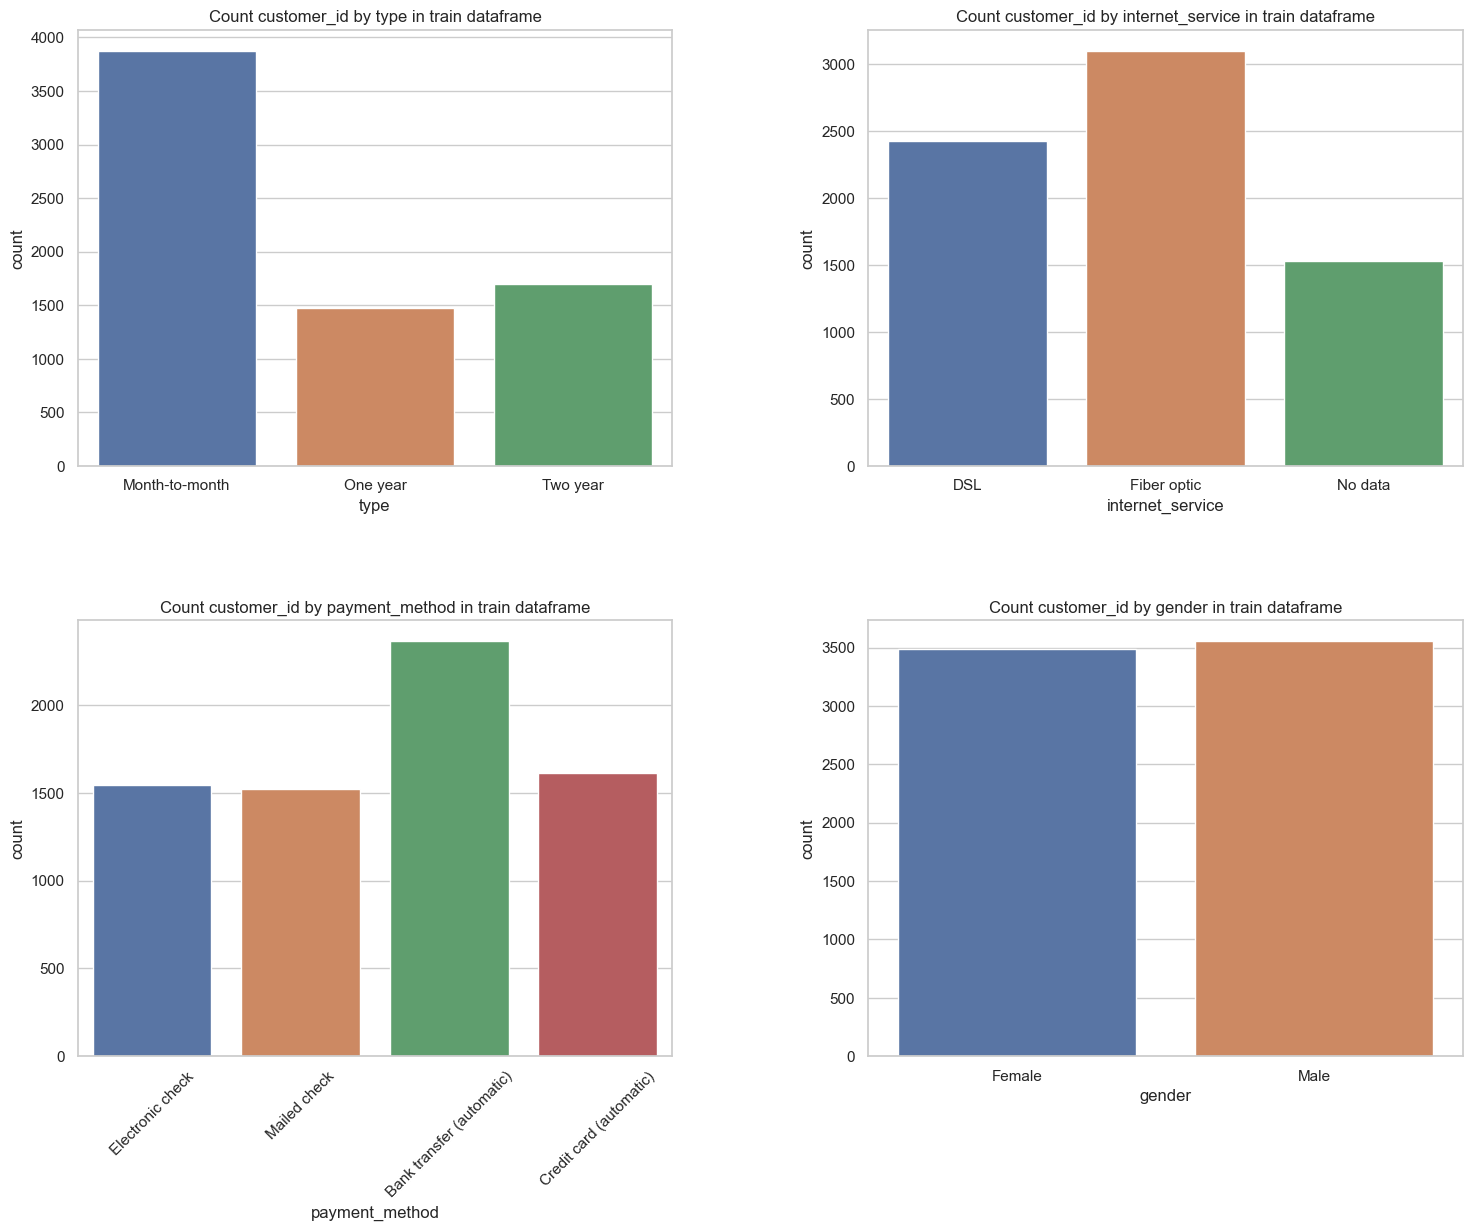

In [21]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)
fig.set_size_inches(16.5, 12.5, forward=True)


x = "type"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg(stat)[y]).reset_index()
sns.barplot(
    data=agg_df,
    x=x,
    y=stat[0],
    ax=axs[0, 0]
)
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg(stat)[y]).reset_index()
sns.barplot(
    data=agg_df,
    x=x,
    y=stat[0],
    ax=axs[1, 0]
)
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);

x = "internet_service"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg(stat)[y]).reset_index()
sns.barplot(
    data=agg_df,
    x=x,
    y=stat[0],
    ax=axs[0, 1]
)
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')


x = "gender"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg(stat)[y]).reset_index()
sns.barplot(
    data=agg_df,
    x=x,
    y=stat[0],
    ax=axs[1, 1]
)
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')


plt.savefig(os.path.join(ASSETS_DIR, "cat_features_1"))

In [22]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ["count"]

In [23]:
df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(
    by=x, ascending=False
).head(10)

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,customer_id
0,0,0,0,0,0,0,0,0,0,1017
3,0,0,0,0,0,0,0,1,1,591
2,0,0,0,0,0,0,0,1,0,251
1,0,0,0,0,0,0,0,0,1,151
4,0,0,0,0,0,0,1,0,0,126
106,0,1,0,0,0,0,0,0,0,105
414,1,1,1,1,1,1,0,1,1,103
8,0,0,0,0,0,1,0,0,0,90
15,0,0,0,0,1,0,0,0,0,86
214,1,0,0,0,0,0,0,0,0,83


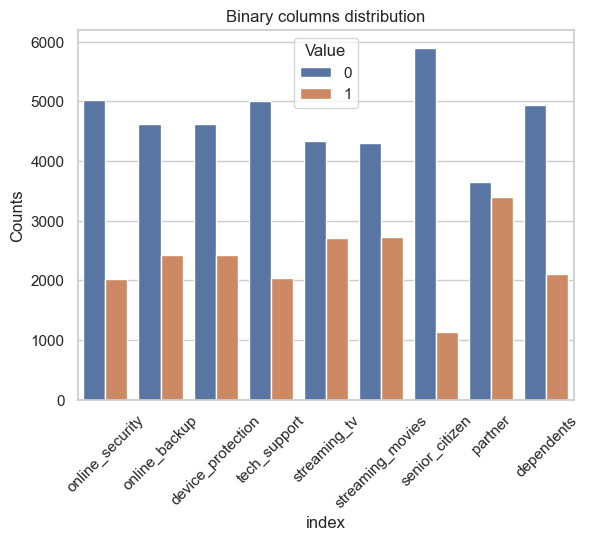

In [24]:
agg_binary = df[binary_columns].apply(pd.Series.value_counts).T.reset_index()
agg_binary_melted = agg_binary.melt(id_vars='index', var_name='Value', value_name='Counts')

sns.barplot(data=agg_binary_melted, x='index', y='Counts', hue='Value')
plt.title(f"Binary columns distribution")
plt.xticks(rotation=45);

plt.savefig(os.path.join(ASSETS_DIR, "cat_features_2_binary"))

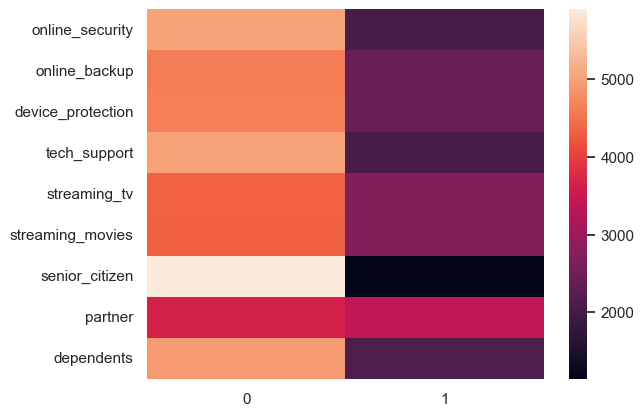

In [25]:
sns.heatmap(df[binary_columns].apply(pd.Series.value_counts).T)

plt.savefig(os.path.join(ASSETS_DIR, "cat_features_2_binary_heatmap"))

In [26]:
x = "begin_date"
charges_columns = [
    "monthly_charges",
    "total_charges",
]
stats = ["mean", "median", lambda x: x.mode().iloc[0]]

In [27]:
charges_monthly_agg = df[[x] + [charges_columns[1]]].groupby([x]).agg(stats).reset_index()
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

charges_total_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

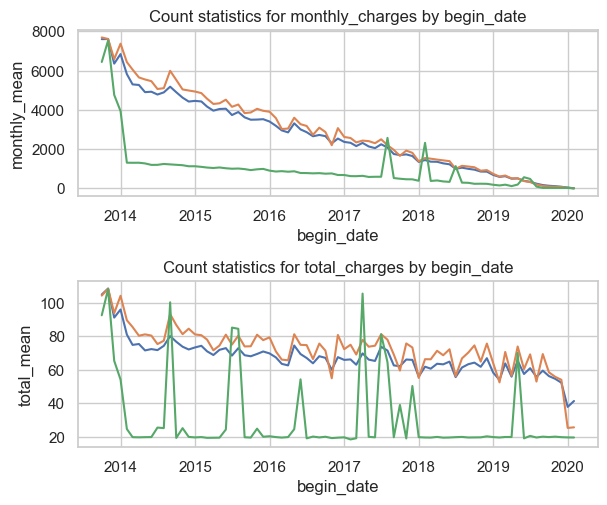

In [28]:
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=2.5)
fig.set_size_inches(6.5, 5.5, forward=True)


sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y="monthly_mean")
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y="monthly_median")
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y="monthly_mode")
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

sns.lineplot(charges_total_agg, ax=axs[1], x=x, y="total_mean")
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y="total_median")
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y="total_mode")
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

plt.savefig(os.path.join(ASSETS_DIR, "charges_by_date"))

##### 4.2 Таргет

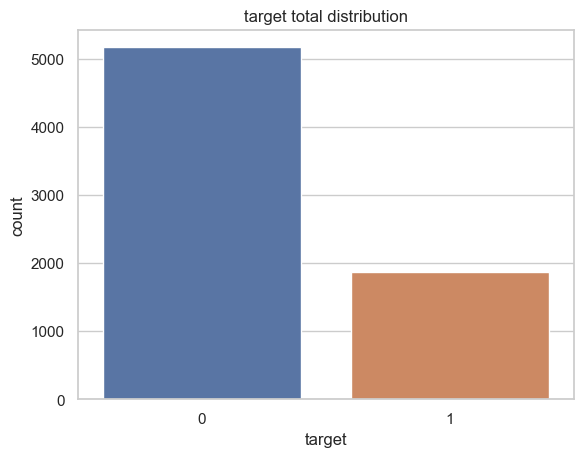

In [29]:
x = "target"
target_agg = df[x].value_counts().reset_index()

sns.barplot(
    data=target_agg,
    x=x,
    y="count",
)
plt.title(f"{x} total distribution")

plt.savefig(os.path.join(ASSETS_DIR, "target_count"))

##### 4.3 Таргет в связке с характеристиками

In [30]:
x = "begin_date"
target = "target"

stat = ["count"]

In [31]:
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

target_agg = df[[x, target, "customer_id"]].groupby([x, target]).count().reset_index()

conversion_agg = df[[x, target]].groupby([x])["target"].agg(["sum", "count"]).reset_index()
conversion_agg["conv"] = (conversion_agg["sum"]/conversion_agg["count"]).round(2)

conversion_agg_gender = df[[x, target, "gender"]].groupby([x, "gender"])[target].agg(["sum", "count"]).reset_index()
conversion_agg_gender["conv"] = (conversion_agg_gender["sum"]/conversion_agg_gender["count"]).round(2)

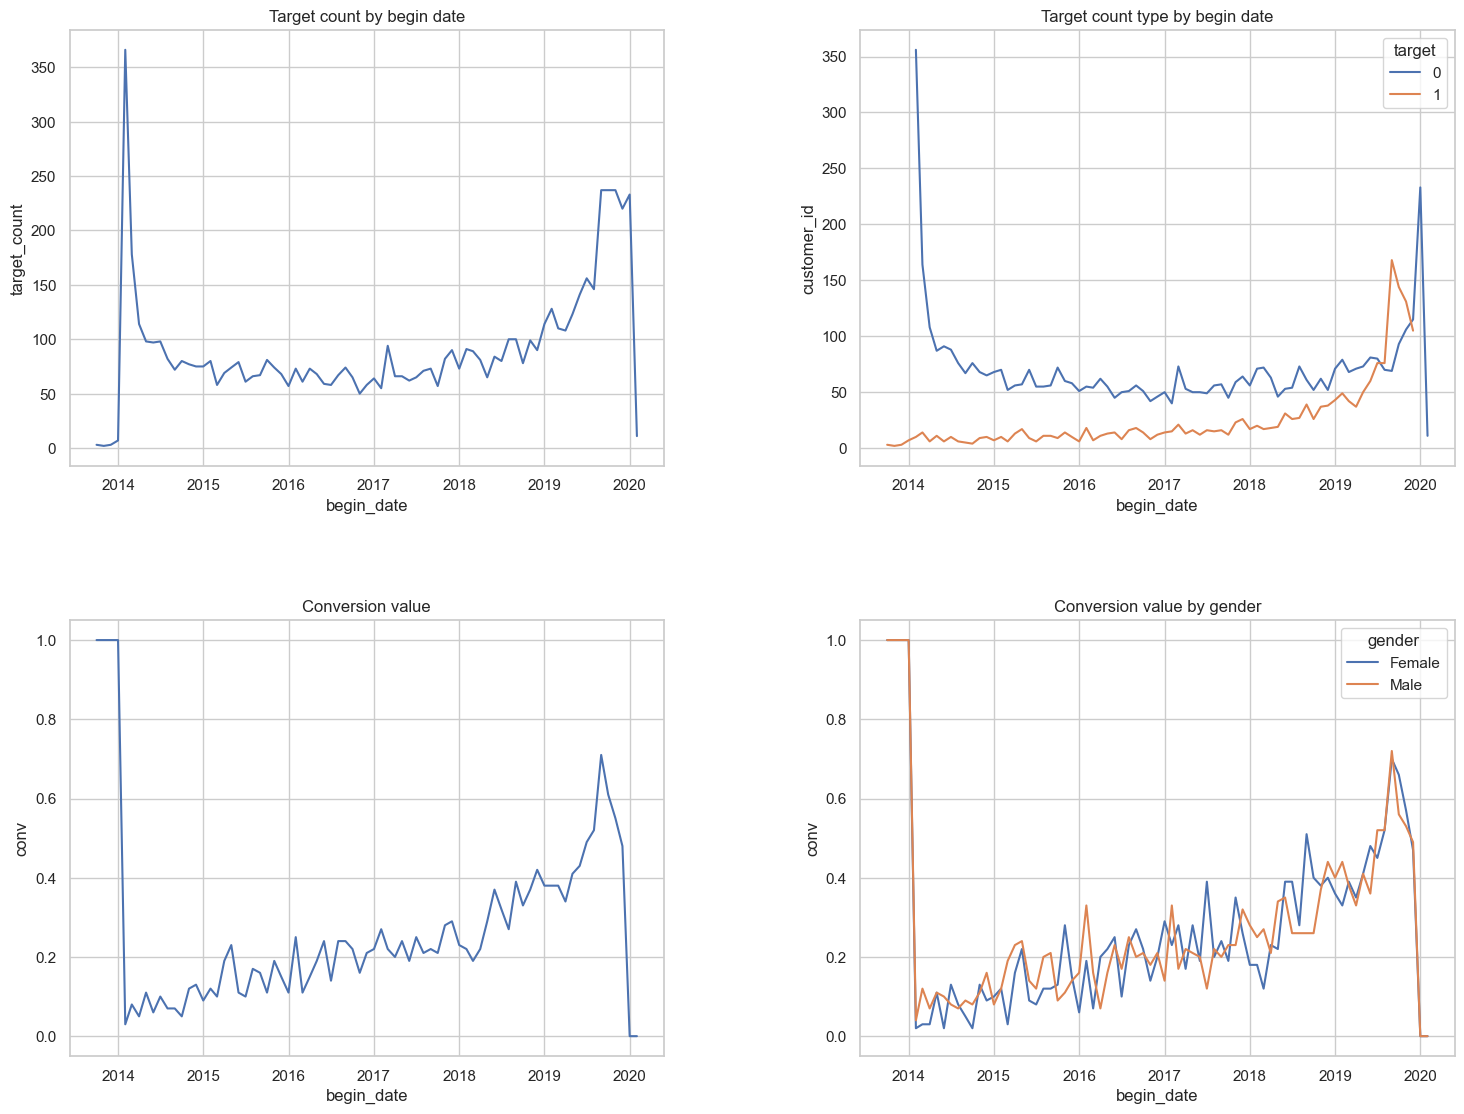

In [32]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)
fig.set_size_inches(16.5, 12.5, forward=True)

sns.lineplot(
    data=target_agg_by_date,
    x=x,
    y="target_count",
    ax=axs[0, 0]
)
axs[0, 0].set_title("Target count by begin date")

sns.lineplot(
    data=target_agg,
    x=x,
    y="customer_id",
    hue=target,
    ax=axs[0, 1]
)
axs[0, 1].set_title("Target count type by begin date")

sns.lineplot(
    data=conversion_agg,
    x=x,
    y="conv",
    ax=axs[1, 0]
)
axs[1, 0].set_title("Conversion value")

sns.lineplot(
    data=conversion_agg_gender,
    x=x,
    y="conv", 
    hue="gender",
    ax=axs[1, 1]
)
axs[1, 1].set_title("Conversion value by gender")


plt.savefig(os.path.join(ASSETS_DIR, "target_by_date"))

In [33]:
x = "end_date"
df["end_date_is_null"] = df["end_date"].isnull()

df.groupby(["end_date_is_null", "target"])["customer_id"].count().reset_index()

,end_date_is_null,target,customer_id
0,False,1,1869
1,True,0,5174


In [34]:
charges = ["monthly_charges", "total_charges"]

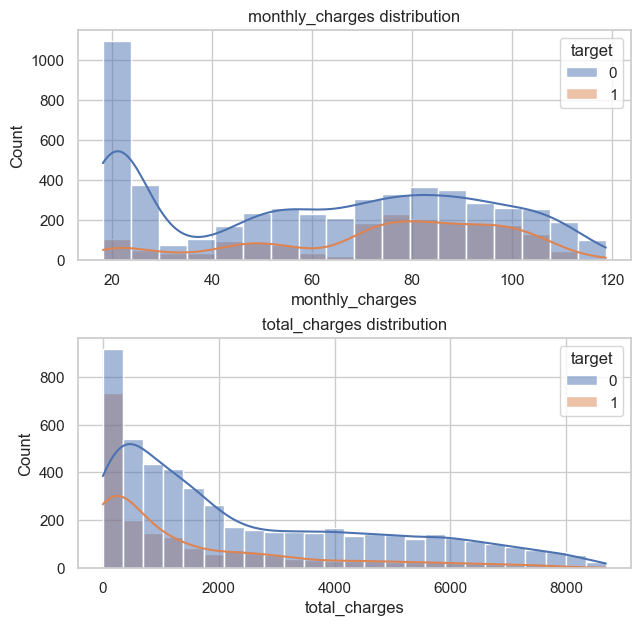

In [35]:
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)
fig.set_size_inches(6.5, 6.5, forward=True)

sns.histplot(
    data=df,
    x=charges[0],
    hue=target,
    kde=True,
    ax=axs[0],
)
axs[0].set_title(f"{charges[0]} distribution")


sns.histplot(
    data=df,
    x=charges[1],
    hue=target,
    kde=True,
    ax=axs[1],
)
axs[1].set_title(f"{charges[1]} distribution")

plt.savefig(os.path.join(ASSETS_DIR, "chargest_by_target_dist"))

##### 5 Сохраним все графики в MLFlow

In [ ]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "..."
os.environ["AWS_ACCESS_KEY_ID"] = "..."
os.environ["AWS_SECRET_ACCESS_KEY"] = "..."

In [41]:
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [42]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR)